In [1]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import utils as ut
import lom


%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater

# Define regions, pipeline for cleaning up glodap data and binning to regions (run once via 'horse' flag)

Text(0.5, 0.98, 'check that norm of colours works')

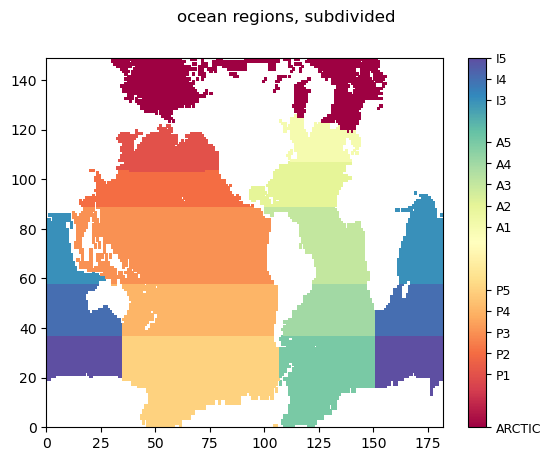

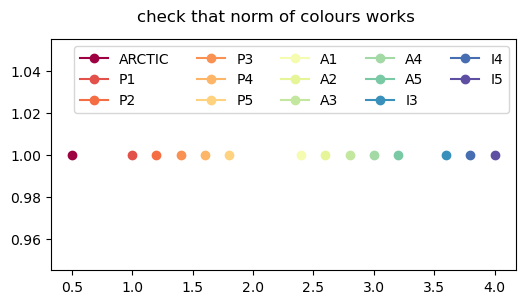

In [2]:
regs = ['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5']

regdict = {'ARCTIC' : {'number' : 0.5},
           'P1' : {'number': 1.0},
          'P2' : {'number': 1.2},
           'P3' : {'number': 1.4},
           'P4' : {'number': 1.6},
           'P5' : {'number': 1.8},
            'A1' : {'number': 2.4},
          'A2' : {'number': 2.6},
           'A3' : {'number': 2.8},
           'A4' : {'number': 3},
           'A5' : {'number': 3.2},
           'I3' : {'number': 3.6},
           'I4' : {'number': 3.8},
           'I5' : {'number': 4},
           
          }
    
tics = []
tcm = 'Spectral'
tmask = nc.Dataset('/gpfs/data/greenocean/software/resources/breakdown/clq_basin_masks_ORCA.nc')

maskno = np.zeros([149,182])
for i in range(0, len(regs)):
    maskno[tmask[regs[i]][:] == 1] = regdict[regs[i]]['number']
    tics.append(regdict[regs[i]]['number'])
maskno[maskno == 0] = np.nan

w = plt.pcolor(maskno, cmap = tcm, vmin = 0.5, vmax = 4)
cbar = plt.colorbar(w, ticks=tics)
t = cbar.ax.set_yticklabels(['ARCTIC', 'P1', 'P2', 'P3', 'P4', 'P5', 'A1', 'A2', 'A3', 'A4', 'A5', 'I3', 'I4', 'I5'], fontsize = 9)
plt.suptitle('ocean regions, subdivided')

fact = 0.2
fig = plt.figure(figsize=(30*fact,15*fact))
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=4)
for i in range(0,len(regs)):
    rgba = cmap(norm(regdict[regs[i]]['number']))
    plt.plot(regdict[regs[i]]['number'], 1, marker = 'o', color = rgba, label = regs[i])
    regdict[regs[i]]['colour'] = rgba
plt.legend(ncol = 5, fontsize = 10)
plt.suptitle('check that norm of colours works')

# Read model data, 1990-2020

In [8]:
import glob

def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

baseDir = '/gpfs/data/greenocean/software/runs/'
tr = 'TOM12_TJ_GEA0'
yrst = 1990
yrend = 2020
dtype = 'ptrc'

tylist = make_yearlist(yrst, yrend, dtype, tr, baseDir)

tdat = xr.open_mfdataset(tylist)
df = tdat

In [9]:
print(df.head(5))

<xarray.Dataset>
Dimensions:               (y: 5, x: 5, deptht: 5, time_counter: 5,
                           axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
  * deptht                (deptht) float32 5.0 15.0 25.0 35.01 45.01
    time_centered         (time_counter) object dask.array<chunksize=(5,), meta=np.ndarray>
  * time_counter          (time_counter) object 1990-01-16 12:00:00 ... 1990-...
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/34)
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 dask.array<chunksize=(5, 5, 2), meta=np.ndarray>
    Alkalini              (time_counter, deptht, y, x) float32 dask.array<chunksize=(5, 5, 5, 5), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object dask.array<chunksize=(5, 2), meta=np.ndarray>
    time_counter_bounds  

In [10]:
tDIC = np.array(df['DIC'][:])
tALK = np.array(df['ALK'][:])


tSAL = np.array(df['SAL'][:])
tTEMP = np.array(df['TEMP'][:])
tPRES = np.array(df['PRES'][:])


dens = seawater.dens(tSAL,tTEMP,tPRES)
tDIC_umolkg = tDIC*1000/dens
tALK_umolkg = tALK*1000/dens

tLAT = np.array(df['LAT'][:])
tLON = np.array(df['LON'][:])
tYEAR = np.array(df['YR'])
tMONTH = np.array(df['MONTH'])
tSTATION = np.array(df['STATION'])
tY = np.array(df['Y'])
tX = np.array(df['X'])
tZ = np.array(df['Zdep'])
tDP = np.array(df['DP'])
tREG = np.array(df['REG'])

type: 'ALK'